<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTS3] - CNN with GTSRB dataset - Monitoring 
<!-- DESC --> Episode 3 : Monitoring and analysing training, managing checkpoints
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - **Understand** what happens during the **training** process
  - Implement **monitoring**, **backup** and **recovery** solutions
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  
Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


## What we're going to do :

 - Monitoring and understanding our model training 
 - Add recovery points
 - Analyze the results 
 - Restore and run recovery points

## Step 1 - Import and init

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix
from skimage import io, transform, color

import matplotlib.pyplot as plt
import seaborn as sn
import os, sys, time, random

from importlib import reload

sys.path.append('..')
import fidle.pwk as ooo

place, datasets_dir = ooo.init()


FIDLE 2020 - Practical Work Module
Version              : 0.57 DEV
Run time             : Wednesday 9 September 2020, 16:14:47
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Current place        : Fidle at IDRIS
Dataset dir          : /gpfswork/rech/mlh/commun/datasets
Update keras cache   : Done


## Step 2 - Load dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use a smart dataset : **set-24x24-L**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [2]:
%%time

def read_dataset(dataset_dir, name):
    '''Reads h5 dataset from dataset_dir
    Args:
        dataset_dir : datasets dir
        name        : dataset name, without .h5
    Returns:    x_train,y_train,x_test,y_test data'''
    # ---- Read dataset
    filename=f'{dataset_dir}/GTSRB/{name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]

    # ---- done
    print('Dataset "{}" is loaded. ({:.1f} Mo)\n'.format(name,os.path.getsize(filename)/(1024*1024)))
    return x_train,y_train,x_test,y_test,x_meta,y_meta

x_train,y_train,x_test,y_test,x_meta,y_meta = read_dataset(datasets_dir, 'set-24x24-L')

Dataset "set-24x24-L" is loaded. (228.8 Mo)

CPU times: user 5.57 ms, sys: 83.5 ms, total: 89.1 ms
Wall time: 278 ms


## Step 3 - Have a look to the dataset
Note: Data must be reshape for matplotlib

x_train :  (39209, 24, 24, 1)
y_train :  (39209,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


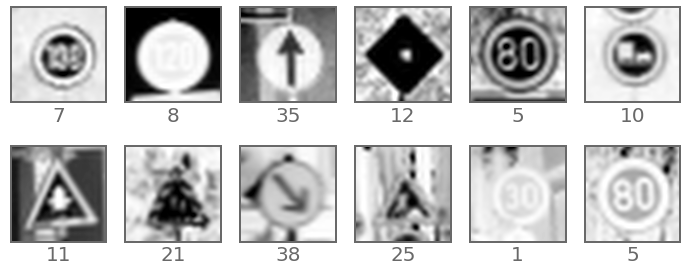

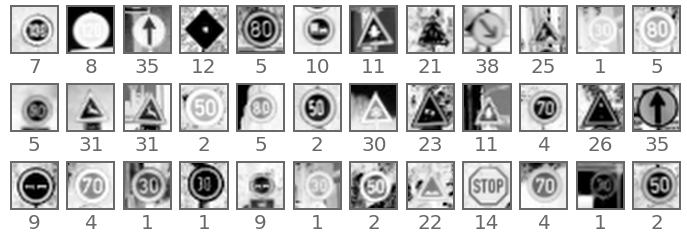

In [3]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

ooo.plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2)
ooo.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1)

## Step 4 - Create model
We will now build a model and train it...

Some models... 

In [4]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## Step 5 - Prepare callbacks  
We will add 2 callbacks :  

**TensorBoard**  
Training logs, which can be visualised using [Tensorboard tool](https://www.tensorflow.org/tensorboard).  
   
  - On your workstation :  
       - Launch a terminal
       - Go to directory containing GTSRB notebooks : `~$ cd fidle/GTSRB/`  
       - Launch :  `~$ tensorboard --logdir ./run/logs`
       - Open : http://localhost:6006
   
   
  - On a GRICAD node :  
       - Launch a terminal
       - Go to directory containing GTSRB notebooks : `~$ cd fidle/GTSRB/`  
       - Launch :  `~$ tensorboard_launch --logdir ./run/logs`
       - Open : http://localhost:6007  
       
       
  - On an IDRIS node :
       - See [IDRIS documentation](http://www.idris.fr/jean-zay/pre-post/jean-zay-jupyter-notebook.html)  


  IMPORTANT : Relaunch tensorboard on every run  

**Model backup**  
 It is possible to save the model each xx epoch or at each improvement.  
 The model can be saved completely or partially (weight).  
 For full format, we can use HDF5 format.

In [5]:
ooo.mkdir('./run/models')
ooo.mkdir('./run/logs')

# ---- Callback tensorboard
log_dir = "./run/logs/tb_" + ooo.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = "./run/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = "./run/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

print(f'To run tensorboard, use :  --logdir ./run/logs')

To run tensorboard, use :  --logdir ./run/logs


## Step 6 - Train the model
**Get the shape of my data :**

In [6]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [7]:
model = get_model_v1(lx,ly,lz)

# model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train it :**  
Note: The training curve is visible in real time with Tensorboard (see step  5)

In [8]:
%%time

batch_size = 64
epochs     = 30

# ---- Shuffle train data
x_train,y_train=ooo.shuffle_np_dataset(x_train,y_train)

# ---- Train
# Note: To be faster in our example, we can take only 2000 values
#
history = model.fit(  x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save('./run/models/last-model.h5')

Epoch 1/30
613/613 [==============================] - 3s 6ms/step - loss: 1.1932 - accuracy: 0.6701 - val_loss: 0.4573 - val_accuracy: 0.8944
Epoch 2/30
613/613 [==============================] - 3s 5ms/step - loss: 0.2293 - accuracy: 0.9339 - val_loss: 0.3381 - val_accuracy: 0.9166
Epoch 3/30
613/613 [==============================] - 3s 5ms/step - loss: 0.1259 - accuracy: 0.9637 - val_loss: 0.2683 - val_accuracy: 0.9313
Epoch 4/30
613/613 [==============================] - 3s 5ms/step - loss: 0.0859 - accuracy: 0.9742 - val_loss: 0.2495 - val_accuracy: 0.9412
Epoch 5/30
613/613 [==============================] - 3s 5ms/step - loss: 0.0702 - accuracy: 0.9782 - val_loss: 0.2693 - val_accuracy: 0.9348
Epoch 6/30
613/613 [==============================] - 3s 5ms/step - loss: 0.0555 - accuracy: 0.9835 - val_loss: 0.2509 - val_accuracy: 0.9389
Epoch 7/30
613/613 [==============================] - 3s 5ms/step - loss: 0.0499 - accuracy: 0.9847 - val_loss: 0.2238 - val_accuracy: 0.9495
Epoch 

**Evaluate it :**

In [9]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9600


In [10]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.3480
Test accuracy  : 0.9584


## Step 7 - History
The return of model.fit() returns us the learning history

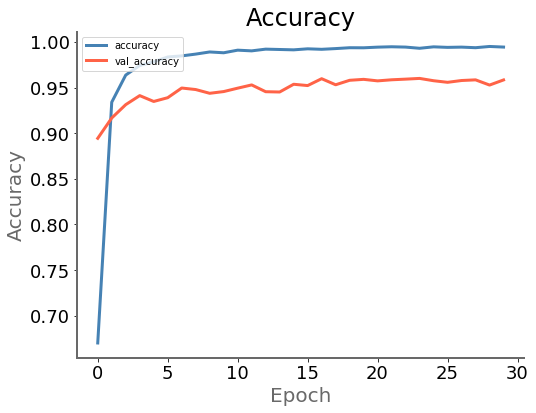

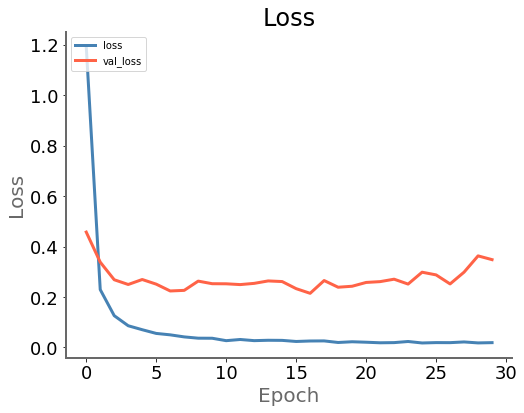

In [11]:
ooo.plot_history(history)

## Step 8 - Evaluation and confusion

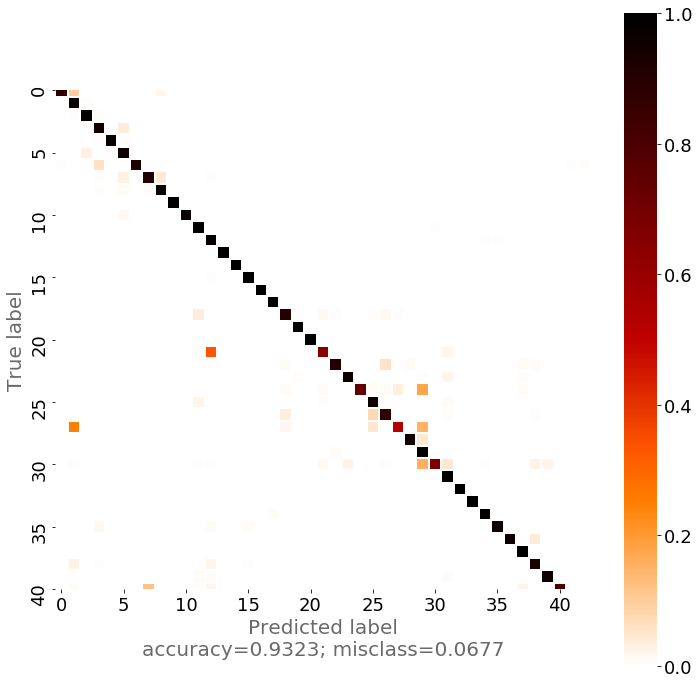

In [14]:
#y_pred   = model.predict_classes(x_test)           Deprecated after 01/01/2021 !!

y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

conf_mat = confusion_matrix(y_test,y_pred, normalize='true', labels=range(43))
ooo.plot_confusion_matrix(conf_mat,figsize=(12, 12),annot=False)

## Step 9 - Restore and evaluate
### 9.1 - List saved models :

In [15]:
!find ./run/models/

./run/models/
./run/models/model-0018.h5
./run/models/model-0019.h5
./run/models/last-model.h5
./run/models/model-0024.h5
./run/models/model-0011.h5
./run/models/model-0017.h5
./run/models/model-0002.h5
./run/models/model-0013.h5
./run/models/model-0016.h5
./run/models/model-0010.h5
./run/models/model-0026.h5
./run/models/model-0004.h5
./run/models/model-0008.h5
./run/models/best-model.h5
./run/models/model-0014.h5
./run/models/model-0028.h5
./run/models/model-0025.h5
./run/models/model-0012.h5
./run/models/model-0005.h5
./run/models/model-0030.h5
./run/models/model-0020.h5
./run/models/model-0015.h5
./run/models/model-0009.h5
./run/models/model-0027.h5
./run/models/model-0007.h5
./run/models/model-0023.h5
./run/models/model-0022.h5
./run/models/model-0029.h5
./run/models/model-0001.h5
./run/models/model-0021.h5
./run/models/model-0006.h5
./run/models/model-0003.h5


### 9.2 - Restore a model :

In [16]:
loaded_model = tf.keras.models.load_model('./run/models/best-model.h5')
# loaded_model.summary()
print("Loaded.")

Loaded.


### 9.3 - Evaluate it :

In [17]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.3629
Test accuracy  : 0.9527


### 9.4 - Make a prediction :


Output layer from model is (x100) :

[[ 0.    0.    6.66  2.88  0.   90.39  0.    0.02  0.    0.    0.    0.    0.05  0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]

Graphically :



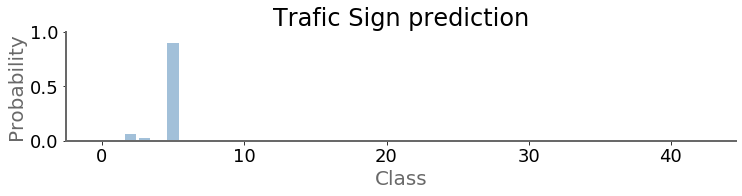


The image :               Prediction :            Real stuff:


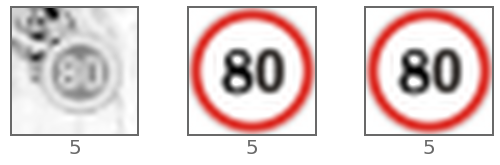

YEEES ! that's right!


In [27]:
# ---- Get a random image
#
i   = random.randint(1,len(x_test))
x,y = x_test[i], y_test[i]

# ---- Do prediction
#
predictions = loaded_model.predict( np.array([x]) )

# ---- A prediction is just the output layer
#
print("\nOutput layer from model is (x100) :\n")
with np.printoptions(precision=2, suppress=True, linewidth=95):
    print(predictions*100)

# ---- Graphic visualisation
#
print("\nGraphically :\n")
plt.figure(figsize=(12,2))
plt.bar(range(43), predictions[0], align='center', alpha=0.5)
plt.ylabel('Probability')
plt.ylim((0,1))
plt.xlabel('Class')
plt.title('Trafic Sign prediction')
plt.show()

# ---- Predict class
#
p = np.argmax(predictions)

# ---- Show result
#
print("\nThe image :               Prediction :            Real stuff:")
ooo.plot_images([x,x_meta[p], x_meta[y]], [p,p,y], range(3),  columns=3,  x_size=3, y_size=2)

if p==y:
    print("YEEES ! that's right!")
else:
    print("oups, that's wrong ;-(")

<div class="todo">
     What you can do:
    <ul>
        <li>Limit model saving: 1 save every 5 epochs </li>
        <li>Use a subset of the dataset</li>
        <li>Try different datasets</li>
        <li>Some exotic signs are waiting to be recognized in dataset_dir/extra !</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
    </ul>
    
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>